In [78]:
# Convolutional Neural Networks for Classification

In [79]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

In [80]:
# Hyperparameters
batch_size = 64
num_epochs = 4
learning_rate = 1e-4
dataset_root = "../datasets"

In [81]:
gpu_index = 0
device = torch.device(gpu_index if torch.cuda.is_available() else "cpu")

In [82]:
# Prepare a composition of transforms
# transforms.Compose will perform the transforms in order
# NOTE: some transform only take in a PIL image, others only a Tensor
# EG Resize and ToTensor take in a PIL Image, Normalize takes in a Tensor
# Refer to documentation
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.308])
])
# Note: ToTensor() will scale unit8 and similar type data to a float and re-scale to 0-1
# Note: We are normalizing with the dataset mean and std 

In [83]:
# Define our MNIST Dataset
train_data = datasets.MNIST(dataset_root, train=True, download=True, transform=transform)
test_data = datasets.MNIST(dataset_root, train=False, download=True, transform=transform)

# We are going tp split test data into train and validation
validation_split = 0.9

# Define the number of samples for each split
n_train_examples = int(len(train_data) * validation_split)
n_valid_examples = len(train_data) - n_train_examples

# The function random_split will take our dataset and split it randomly and give us dataset
# that are the sizes we gave it
# Note: we can split it into to more then two pieces!
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples], generator=torch.Generator().manual_seed(42))
# IMPORTANT TO KNOW!!!!!!!!!
# Here we pass the random_split function a manual seed, this is very important as if we did not do this then 
# everytime we randomly split our training and validation set we would get different splits!!!
# For example if we saved our model and reloaded it in the future to train some more, the dataset that we now use to
# train with will undoubtably contain datapoints that WERE in the validation set initially!!
# Our model would therefore be trained with both validation and training data -- very bad!!!
# Setting the manual seed to the same value everytime prevents this!


In [84]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [85]:

# Create the training, Validation and Evaluation/Test Datasets
# It is best practice to separate your data into these three Datasets
# Though depending on your task you may only need Training + Evaluation/Test or maybe only a Training set
# (It also depends on how much data you have)
# https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataloader
train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = dataloader.DataLoader(valid_data, batch_size=batch_size)
test_loader = dataloader.DataLoader(test_data, batch_size=batch_size)

In [86]:
class LeNet(nn.Module):
    def __init__(self, channels_in):
        # Call the __init__ function of the parent nn.module class
        super(LeNet, self).__init__()
        # Define Convolution Layers
        # conv1 6 channels_inx5x5 kernels
        self.conv1 = nn.Conv2d(channels_in, 6, kernel_size=5)
        
        # conv2 16 6x5x5 kernels
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        
        # Define MaxPooling Layers
        # Default Stride is = to kernel_size
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Define Linear/Fully connected/ Dense Layers
        # Input to linear1 is the number of features from previous conv - 16x5x5
        # output of linear1 is 120
        self.linear1 = nn.Linear(16*5*5, 120)
        # output of linear2 is 84
        self.linear2 = nn.Linear(120, 84)
        # output of linear3 is 10
        self.linear3 = nn.Linear(84, 10)
            
    def forward(self, x):
        # Pass input through conv layers
        # x shape is BatchSize-3-32-32
        
        out1 = F.relu(self.conv1(x))
        # out1 shape is BatchSize-6-28-28
        out1 = self.maxpool(out1)
        # out1 shape is BatchSize-6-14-14

        out2 = F.relu(self.conv2(out1))
        # out2 shape is BatchSize-16-10-10
        out2 = self.maxpool(out2)
        # out2 shape is BatchSize-16-5-5

        # Flatten out2 to shape BatchSize-16x5x5
        out2 = out2.view(out2.shape[0], -1)
        
        out3 = F.relu(self.linear1(out2))
        # out3 shape is BatchSize-120
        out4 = F.relu(self.linear2(out3))
        # out4 shape is BatchSize-84
        out5 = self.linear3(out4)
        # out5 shape is BatchSize-10
        return out5

In [87]:
# Create a dataloader itterable object
dataiter = iter(test_loader)
# Sample from the itterable object
test_images, test_labels = dataiter._next_data()

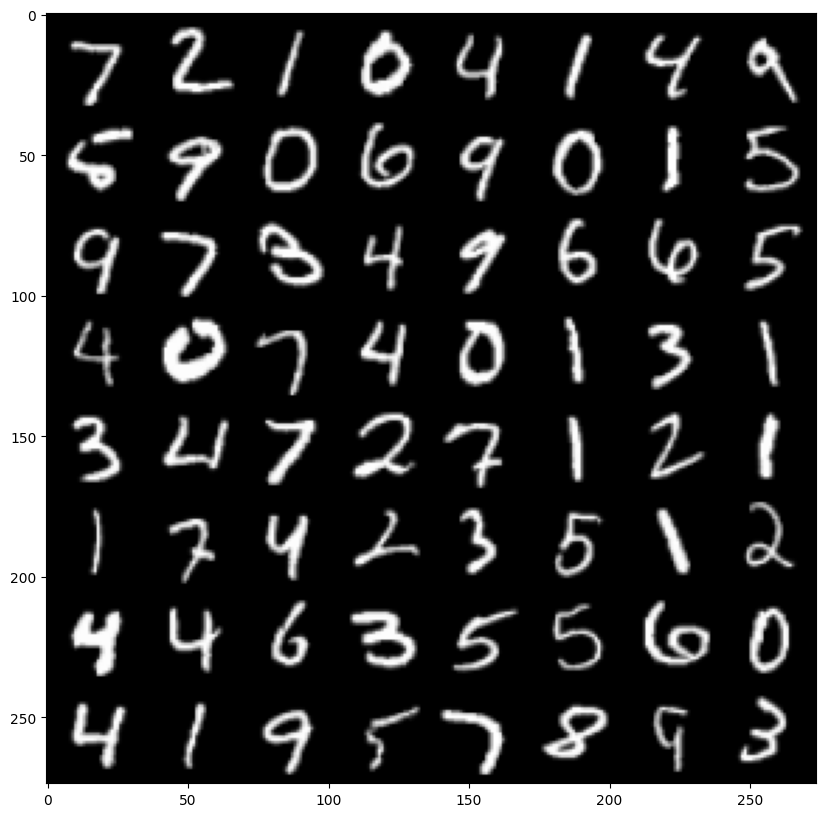

In [88]:

# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [89]:
# Create an instance of our network
# Set channels_in to the number of channels of the dataset images (1 channel for MNIST)
model = LeNet(channels_in = test_images.shape[1]).to(device)

# View the network
# Note that the layer order is simply the order in which we defined them, NOT the order of the forward pass
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)


In [90]:

# Pass image through network
out = model(test_images.to(device))
# Check output
out.shape

torch.Size([64, 10])

In [91]:

# Pass our network parameters to the optimiser set our lr as the learning_rate
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [92]:

# Define a Cross Entropy Loss
loss_fun = nn.CrossEntropyLoss()

In [93]:
# This function should perform a single training epoch using our training data
def train(model, optimizer, loader, device, loss_fun, loss_logger):
    
    # Set Network in train mode
    model.train()
    for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Training")):
        # Forward pass of image through network and get output
        fx = model(x.to(device))
        
        # Calculate loss using loss function
        loss = loss_fun(fx, y.to(device))

        # Zero Gradents
        optimizer.zero_grad()
        # Backpropagate Gradents
        loss.backward()
        # Do a single optimization step
        optimizer.step()
        
        # Log the loss for plotting
        loss_logger.append(loss.item())
        
    # Return the avaerage loss and acc from the epoch as well as the logger array       
    return model, optimizer, loss_logger

In [94]:
# This function should perform a single evaluation epoch, it WILL NOT be used to train our model
def evaluate(model, device, loader):
    
    # Initialise counter
    epoch_acc = 0
    
    # Set network in evaluation mode
    # Layers like Dropout will be disabled
    # Layers like Batchnorm will stop calculating running mean and standard deviation
    # and use current stored values (More on these layer types soon!)
    model.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Evaluating")):
            # Forward pass of image through network
            fx = model(x.to(device))
            
            # Log the cumulative sum of the acc
            epoch_acc += (fx.argmax(1) == y.to(device)).sum().item()
            
    # Return the accuracy from the epoch     
    return epoch_acc / len(loader.dataset)

In [95]:

training_loss_logger = []
validation_acc_logger = []
training_acc_logger = []

In [96]:
# This cell implements our training loop
for epoch in trange(num_epochs, leave=False, desc="Epoch"):
    
    # Call the training function and pass training dataloader etc
    model, optimizer, training_loss_logger = train(model=model, 
                                                   optimizer=optimizer, 
                                                   loader=train_loader, 
                                                   device=device, 
                                                   loss_fun=loss_fun, 
                                                   loss_logger=training_loss_logger)
    
    # Call the evaluate function and pass the dataloader for both ailidation and training
    train_acc = evaluate(model=model, device=device, loader=train_loader)
    valid_acc = evaluate(model=model, device=device, loader=valid_loader)
    
    # Log the train and validation accuracies
    validation_acc_logger.append(valid_acc)
    training_acc_logger.append(train_acc)


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training Complete


Text(0.5, 1.0, 'LeNet Training Loss')

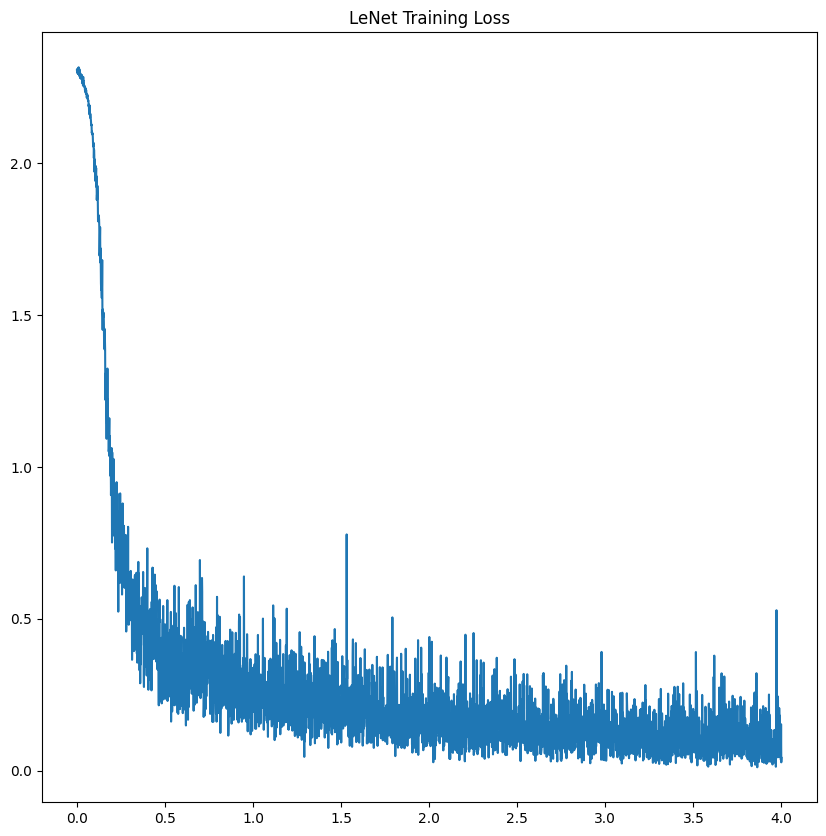

In [97]:
    
print("Training Complete")
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger)
plt.title("LeNet Training Loss")

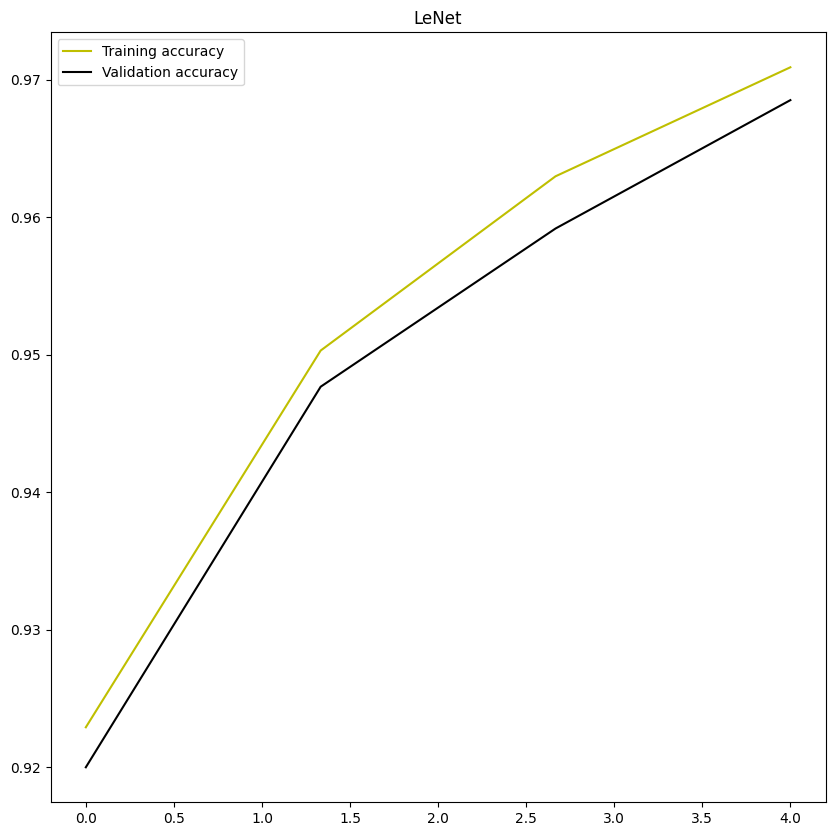

In [98]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(training_acc_logger))
plt.plot(train_x, training_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_acc_logger))
plt.plot(valid_x, validation_acc_logger, c = "k")

plt.title("LeNet")
plt.legend(["Training accuracy", "Validation accuracy"])

In [99]:
# Call the evaluate function and pass the evaluation/test dataloader etc
test_acc = evaluate(model=model, device=device, loader=test_loader)
print("The total test accuracy is: %.2f%%" %(test_acc*100))

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

The total test accuracy is: 97.21%


Predicted Values
 [np.int64(7), np.int64(2), np.int64(1), np.int64(0), np.int64(4), np.int64(1), np.int64(4), np.int64(9)]
True Values
 [np.int64(7), np.int64(2), np.int64(1), np.int64(0), np.int64(4), np.int64(1), np.int64(4), np.int64(9)]


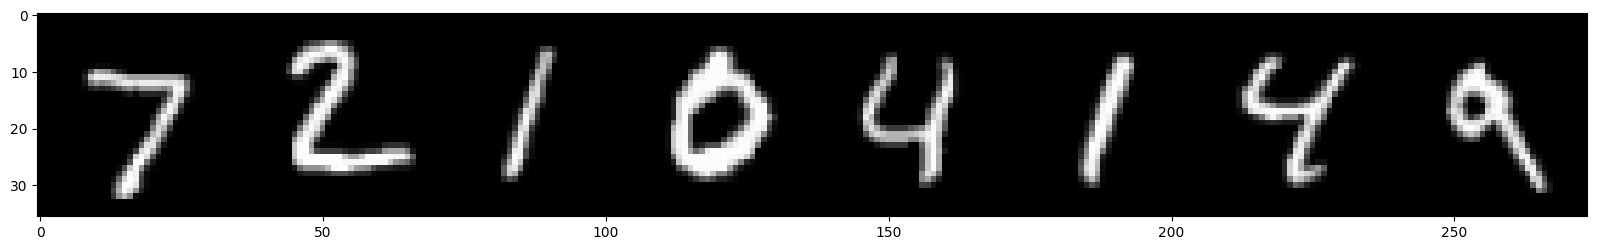

In [100]:
# Lets visualise the prediction for a few test images!

with torch.no_grad():
    fx = model(test_images[:8].to(device))
    pred = fx.argmax(-1)
    
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images[:8], 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

print("Predicted Values\n", list(pred.cpu().numpy()))
print("True Values\n", list(test_labels[:8].numpy()))

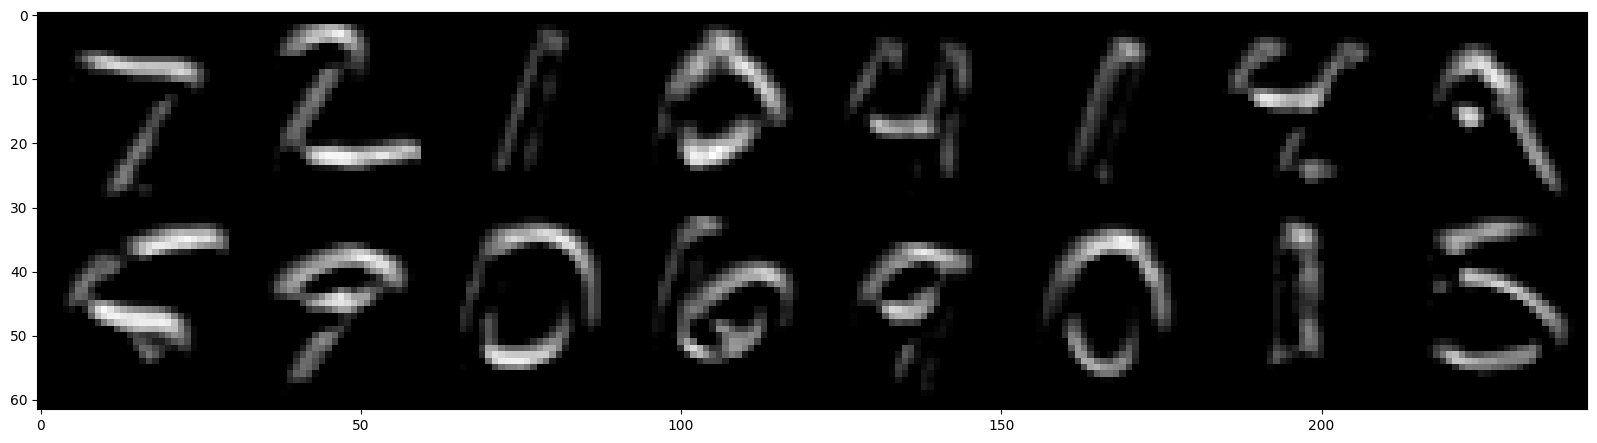

In [101]:

with torch.no_grad():
    model_out = F.relu(model.conv1(test_images.to(device)))
    
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(model_out[:16, 5].unsqueeze(1).detach().cpu(), 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

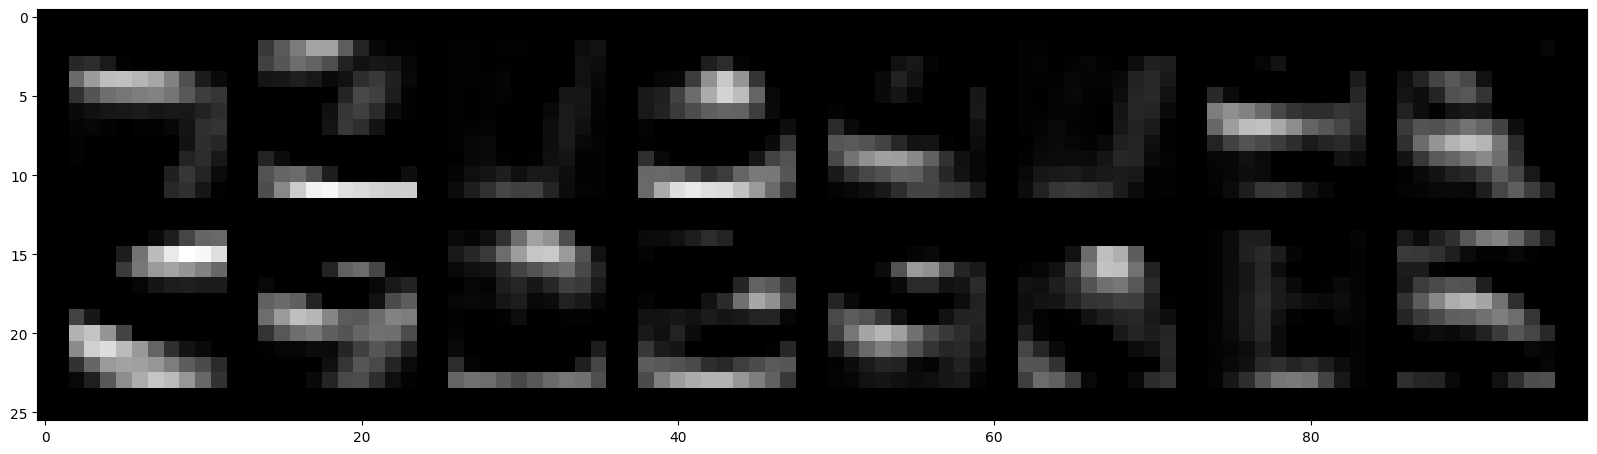

In [102]:

with torch.no_grad():
    model_out2 = F.relu(model.conv2(model.maxpool(F.relu(model.conv1(test_images.to(device))))))
    
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(model_out2[:16, 10].unsqueeze(1).detach().cpu(), 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))